[View in Colaboratory](https://colab.research.google.com/github/orico/PCAvsAutoencoder/blob/master/PCA_vs_Autoencoder_tutorial.ipynb)

A lot have been written about using a linearly activated autoencoder (AE) to approximate principal component analysis (PCA). From a math point of view, minimizing the reconstruction error in PCA is the same as AE [1]. However, why limit ourselves to linear transformations? Neural nets are very flexible, therefore we can introduce nonlinearities by using nonlinear activation functions [2]. Our Hypothesis is that the subspace spanned by the AE will be similar to the one found by PCA [3]. Additionaly, a technical disadvantage of using PCA is the requirement to run it again whenever new data is introduces, a 'feature' lacking in neural nets.

In this study we'll see the similarities and differences between PCA, a linear and non linear autoencoders. 
Note: Please read [4] if you dont have a background with AE.

[1] [CSC 411: Lecture 14: Principal Components Analysis &
Autoencoders](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf), page 16.

[2] [A Tutorial on Autoencoders for Deep Learning](https://lazyprogrammer.me/a-tutorial-on-autoencoders/)

[3] [what are the differences between pca and autoencoder](https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder) 

[4] [building AE in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

In [1]:
import keras
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

Using TensorFlow backend.


First, lets load up the Iris data-set and scale it between [0,1].

In [0]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Then we use the data-set to fit a PCA and plot the first two PCs against each other, clearly two clusters emerge.

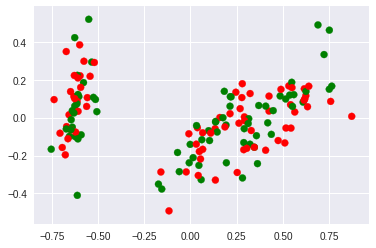

In [3]:
pca = decomposition.PCA()
pca_transformed = pca.fit_transform(X_scaled)
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],color=['red','green'])
plt.show() 

Our first network is a linear AE that has 3 layers (encoding, hidden and decoding), the encoding and decoding layers have 'linear activations' and the hidden layer has 2neurons. Essentially this structure approximates PCA by reducing the data from 4 features to 2 features in the hidden layer. As you can see the model converges quite nicely and our validation loss has dropped to zero. After passing the training data through the hidden layer we get two new vectors and by plotting them against each other we clearly show two nice clusters. We'll get to these clusters later on.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


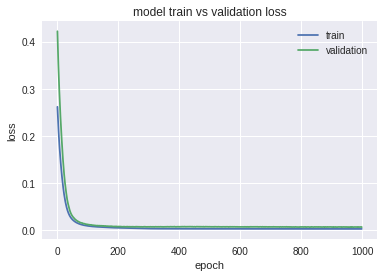

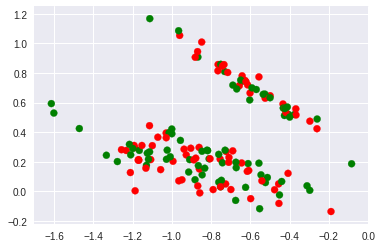

In [5]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plt.scatter(encoded_data[:,0],encoded_data[:,1],color=['red','green'])
plt.show() 


Lets create a second AE, this time we'll replace both linear activation functions with a sigmoid. This network structure can be thought of PCA with nonlinear transformation and similarly to the one above it converges to a local minimum and we can plot the resulting dense-vectors. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


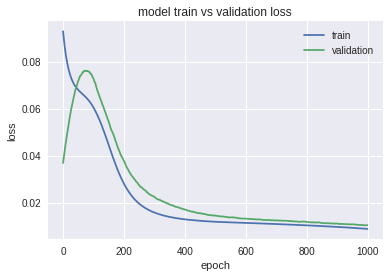

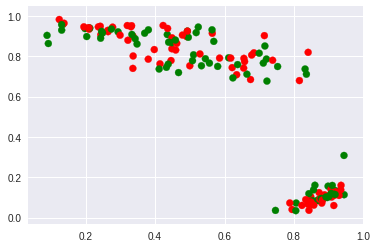

In [6]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2  
input_img2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_img2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')
print(autoencoder2.summary())

history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=2000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_img2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plt.scatter(encoded_data2[:,0],encoded_data2[:,1],color=['red','green'])
plt.show()

Our last AE uses relu activation with an L2 regularizer. It is another way of saying that we want to approximate PCA by using a non-linear AE with constrained representations [4]. Similarly to the Previous networks it converges to a local minimum and both dense-vectors show a two clusters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


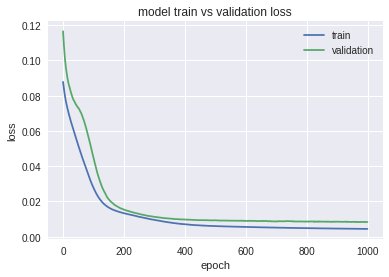

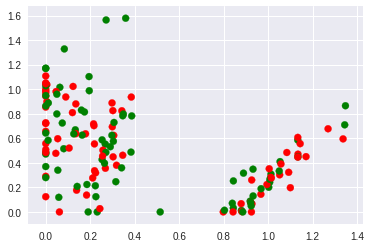

In [25]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2  
input_img3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l2(10e-5))(input_img3)
decoded3 = Dense(input_dim3, activation='sigmoid')(encoded3)
autoencoder3 = Model(input_img3, decoded3)
autoencoder3.compile(optimizer='adam', loss='mse')
print(autoencoder3.summary())

history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder3 = Model(input_img3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plt.scatter(encoded_data3[:,0],encoded_data3[:,1],color=['red','green'])
plt.show() 


After training all 3 autoencoders and pushing our training data through the hidden layer, we compare the first 2 PCs and the AE's dense features. We can clearly see that the figures in these vectors are not the same, across all models. This is very clear from plotting each two vectors and looking at the configurability of the clusters. Next we would like to compare how a simple KMEANS with 2 clusters labels the data.

In [26]:
print('PCA\n',pca_transformed[:,0:2][0:10])
print()
print('Linear AE\n',encoded_data[0:10])
print()
print('Nonlinear AE with sigmoid\n',encoded_data2[0:10])
print()
print('Nonlinear AE with relu\n',encoded_data3[0:10])


PCA
 [[-0.63036125  0.11155626]
 [-0.62354631 -0.1003132 ]
 [-0.6697928  -0.04722006]
 [-0.65463305 -0.09879127]
 [-0.64826327  0.13755769]
 [-0.534057    0.29322304]
 [-0.65639589  0.01492194]
 [-0.62564396  0.06107532]
 [-0.67652584 -0.19648232]
 [-0.64613717 -0.06324223]]

Linear AE
 [[-0.62788975  0.7500178 ]
 [-0.4053869   0.52008855]
 [-0.43376258  0.5905049 ]
 [-0.375356    0.5195364 ]
 [-0.64187104  0.7806278 ]
 [-0.8672814   0.9073841 ]
 [-0.49916616  0.6463293 ]
 [-0.5698963   0.6882458 ]
 [-0.26060858  0.42358178]
 [-0.4246997   0.5596666 ]]

Nonlinear AE with sigmoid
 [[0.877193   0.08107407]
 [0.9088016  0.14371262]
 [0.9154188  0.11005004]
 [0.91935724 0.13413666]
 [0.88012993 0.07199891]
 [0.806308   0.07251133]
 [0.9083428  0.10204269]
 [0.8854994  0.09527696]
 [0.9355361  0.16030683]
 [0.907239   0.12033226]]

Nonlinear AE with relu
 [[1.0516672  0.3024261 ]
 [0.84344226 0.03210378]
 [0.92719054 0.0658319 ]
 [0.8796653  0.01221687]
 [1.0921913  0.32299167]
 [1.1330715 

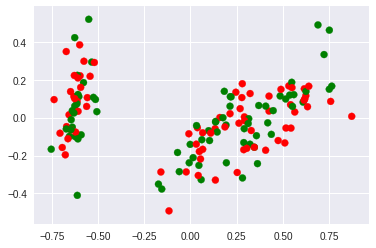

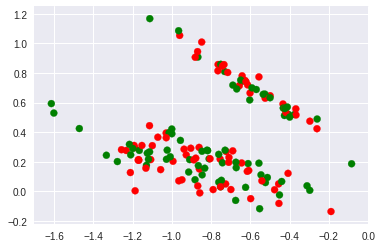

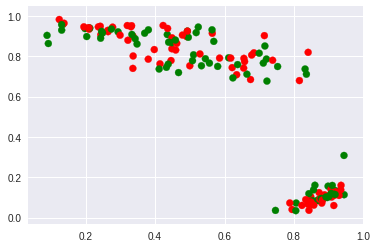

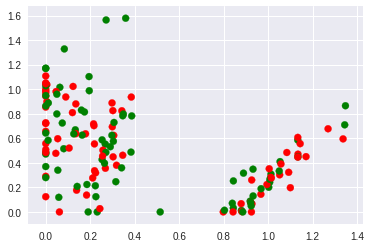

In [27]:
plt.scatter(pca_transformed[:,0],pca_transformed[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data[:,0],encoded_data[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data2[:,0],encoded_data2[:,1],color=['red','green'])
plt.show()  

plt.scatter(encoded_data3[:,0],encoded_data3[:,1],color=['red','green'])
plt.show() 

We would like to know if each result, clustered with KMEANS (k=2), can label the data similarly across all models, even if the dense range is very different. The following is a printed classification vector for the samples in the training set. The printed output clearly shows, that using different dense representation that were created by different algorithms, can be clustered into two identical clusters, repeatedly. However, please keep in mind that minor differences can happen due to the random nature of neural networks.

In [29]:
estimators = [('PCA'    , KMeans(n_clusters=2), pca_transformed),
              ('AE linear' , KMeans(n_clusters=2), encoded_data),
              ('AE sigmoid' , KMeans(n_clusters=2), encoded_data2),
              ('AE relu', KMeans(n_clusters=2), encoded_data3)]
fignum = 1
titles = ['PCA', 'Linear AE', 'Sigmoid AE', 'Relu AE']
for name, est, data in estimators:
    X = data
    est.fit(X)
    labels = est.labels_
    print(name,':')
    print(labels[:])

PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE linear :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE sigmoid :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
AE relu :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 